# Simple LPC example

This notebook a simple LPC example with an audio file built with some of the basic functionality of librosa version 0.4.

Following through this example, you'll learn how to:

* Load audio input
* Calulatate the energy of a voice signal
* make a threshold between voiced and unvoiced signal
* Mount the predictor equations
* Solve the Toeplitz matrix with levinson algorithm
* filter the signal back 

In [1]:
from __future__ import print_function

In [2]:
# We'll need numpy for some mathematical operations
import numpy as np

#from scipy.fftpack import fft, ifft

#from scikits.talkbox.tools import nextpow2

#from scikits.talkbox.linpred._lpc import levinson as c_levinson

# I leave some libraries to try some other exercices with the same code

# Librosa for audio operations 
import librosa

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline
#librosa.display is separate from librosa
import librosa.display
# and IPython.display for audio output
import IPython.display

In [10]:
audio_path = librosa.util.example_audio_file()

# or point it at another audio file (look the requirements for librosa):

#audio_path='/home/valner/Documents/ensino/topicos especiais/lpc/valner.flac'
audio_path='EDIT YOU OWN PATH HERE'

z, sr = librosa.load(audio_path,sr=8000); # this is my test song file (im using 8 kHz sample rate)
zz=z;
data_o=z;
# Play it back, if you want!
#IPython.display.Audio(data=z, rate=sr)

#print(zz); # just in case you cannot hear... take a look at the read data

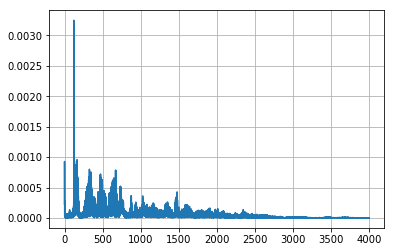

63600


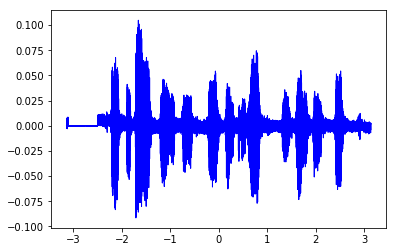

In [11]:
from scipy.fftpack import fft # lets take a look at the spectrum of the file
# Number of sample points
N = np.size(zz)
# sample spacing
T = 1.0 / 8000.0
x = np.linspace(0.0, N*T, N)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(zz)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

# if every thing is ok, we'll be able to see the spectrum of the voice signal

nsamples=np.size(z) #determines the total number of samples

z.shape=[nsamples,1] #transforms in a column
nframes=np.floor(nsamples/240)  # we want to break the data vector into 30 ms frames
s=240*nframes 

zz=z 
i=nsamples-1 

while i>=s:
    zz=np.delete(zz, i, 0)
    i=i-1 #remove the exceeding elements from the data vector, if necessary.
print(np.size(zz)) # this number should be an integer number of frames (240 samples x nframes)
#print(nframes)
#print(np.size(zz))
X= np.linspace(-np.pi, np.pi, nsamples, endpoint=True)
plt.plot(X, z, color="blue", linewidth=1.0, linestyle="-")
plt.show() # lets take a look at the raw data ... it should look like a sound signal (obsviously)


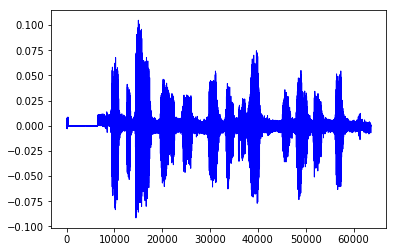

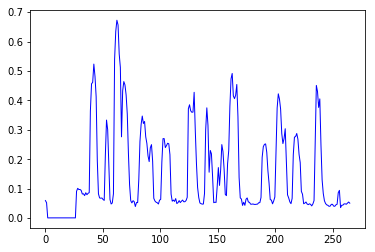

In [13]:
A=np.reshape(zz,(int(nframes),240)) #mount the column vectors of 240 samples
A=A.transpose() 

## IF WE WANT TO CHECK, WE MUST BE ABLE TO RECONSTRUCT A VECTOR FROM THE MATRIX OF FRAMES 
for i in range(0,int(nframes)):
    if(i==0):
        vetor_a=A[:,i]
    else:
        vetor_a=np.r_[vetor_a,A[:,i]]


X= np.linspace(0, np.size(vetor_a), np.size(vetor_a), endpoint=True)
plt.plot(X, vetor_a, color="blue", linewidth=1.0, linestyle="-")
plt.show(); # IS THE ORIGINAL SIGNAL BACK, IT SHOULD BE !!!


#l=0; 
#NOW LETS CALCULATE THE ENERGY OF THE FRAMES
for i in range(0,int(nframes)):
    result=np.sqrt(np.sum(np.square(A[:,i]))) #square root of the square sum
    if (i==0):
        energy=result
    else:
        energy = np.r_[energy, result]; #EACH FRAME WILL HAVE A ENERGY VALUE, WHICH WILL BE SAVED
X= np.linspace(0, np.size(energy), np.size(energy), endpoint=True)
plt.plot(X, energy, color="blue", linewidth=1.0, linestyle="-")
plt.show(); #print on the screen the energy of each slice of data.   

In [14]:
# OK, NOW WE WANT TO FIND OUT IF THE FRAME IS VOICE OR UNVOICED
# AN EASY WAY TO FIND THIS OUT ID TO COUNT THE NUMBER OF TRANSITIONS FROM 0 TO 1 OR 1 TO ZERO

count=0;
ii=0;

for i in range(0,int(nframes)):
    for ii in range(1,240):
        if ((((A[ii,i]) > 0.0) and ((A[ii-1,i]) < 0.0)) or (((A[ii,i]) < 0.0) and ((A[ii-1,i]) > 0.0))):
            count=count+1
    if (count<100): # THIS IS THE THRESHOLD (YOU CAN CHANGE THIS VALUE TO SEE WHAT HAPPENS!) 
        vu=1 #IF THERE ARE FEW TRANSITIONS THEN THE FRAME IS SET UNVOICED
    else: 
        vu=0 # IF THERE ARE MANY TRANSITIONS THE FRAME IS VOICED
    if (i==0):
        array_vu=vu #LOAD THE FIRST VALUE OF THE ARRAY
    else:
        array_vu=np.r_[array_vu,vu] #MONT THE OUTPUT ARRAY (THIS ARRAY COMMANDS THE SWITCH, CHOOSING INPUT AS  )
                                    #WHITE NOISE OR A TRAIN OF PULSES
    count=0

#print(np.size(array_vu)); WE SHOULD HAVE THE SAME NUMBER OF FRAMES (ONE DECISION PER FRAME)

# Here we begin LPC

In [17]:
from scipy.linalg import toeplitz #THATS WHY I LOVE PYTHON! - SOMEONE DID THE DIRTY JOB!! 
from scipy.linalg import solve_toeplitz, toeplitz
# SO, LETS IMPORT THE LIBRARIES IN ORDER TO SOLVE THE CORRELATIONS TOEPLITZ MATRICES

for i in range(0,int(nframes)):
    P=15     #total size of the filter - number of coeficients (HEY PALE, YOU CAN CHOOSE - BUT CAUTION!!! YOU NEED TO
             #CHANGE SOME THINGS IN THIS CODE - NOT THAT MUCH, BUT I'LL LEAVE IT TO YOU!   
    x=A[:,i] # PICK A FRAME AT TIME
    xsize=np.size(x);
    ii=0;
    #x is the column vector of data and P is the high order of the coeficients
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    cor=np.correlate(x, x, "full") # calculate the autocorrelation R of vector x
    
    #notice this function give us the data from index -k to k.
    #however we want Rss(0) until Rss(k), where x={x0,x1,...,xn}
    #Rss(0)=sum(x_0^2, x_1^2...) and Rss(k)=x_0*xn
    
    #array_R=np.array([0])
    
    for ii in range((xsize-1),np.size(cor),P):# xsize is the length of the vector (240), P is the lag
        # so, the for starts from 239 or R(0) until 479 ou R(240)
        # for loop to fix the mount Rss      
        # correlation has 2xlength; we search for Rss(0) which is on the center 
        COR=cor[ii]
        if (ii==(xsize-1)):
            array_R = COR #load R(0)
            
        else:
            array_R = np.r_[array_R,COR] #then build the whole array R
        
    # NOW, WE START TO BUILD THE PARAMETERS FOR LOADING THE SOLVE_LEVINSON FUNCTION  
    rss=array_R[1:P+1]
    #print(rss);
    rss1=array_R[0:P]
    c=rss1
    b=rss
    
    #x = solve_toeplitz((c,c), b)
    x = solve_toeplitz((c,c), b) # I REALLY SUGGEST YOU TAKE A LOOK IN THE DOCUMENTATION IN ORDER TO 
                                 # UNDERSTAND THIS STEP - THE TOEPLITZ MATRIX IS A SYMETRICAL MATRIX
    if i==0: #if this is the first time assign y the vector x
        y=x;
    else:
        y = np.c_[y, x];#this is the filter coeff 
        # BUILD THE VECTORS COEFFICIENTS
#print(y[:,0]);
    

# Almost filtering...

/home/valner/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/valner/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in divide


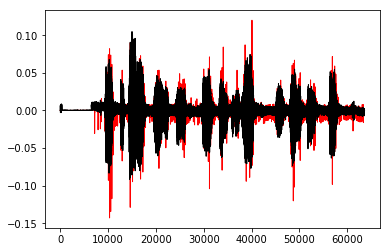

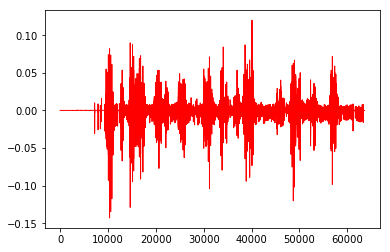

[  1.55261209e-09  -1.94762371e-09   2.44313320e-09 ...,  -1.32782911e-05
  -2.21122388e-05  -1.93340208e-06]


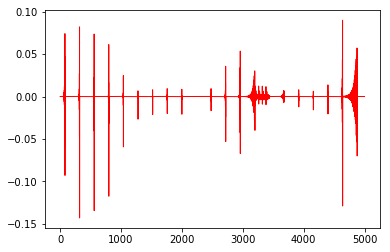

In [27]:
# HOPEFULY WE HAVE THE SIGNAL DATA CHARACTERIZED INTO FRAMES OF VOICE AND UNVOICED,
# WE SHOULD ALSO HAVE 15 COEFF PER FRAME (240 SAMPLES)
# NOW, WE SHOULD RECONSTRUCT THE SIGNAL...

s=np.empty(240, dtype=np.float64)
out=np.empty(240, dtype=np.float64)
np.array(out, dtype='float64')
x1=np.dtype('f8')
x2=np.dtype('f8')
x3=np.dtype('f8')
c=np.array([1])

from scipy.signal import lfilter # LETS IMPORT THE FILTER FUNCTION

for i in range(0,int(nframes)):
    if (array_vu[i]==1):
        a = np.ones(1)
        b = np.zeros(59)
        s=np.r_[a, b] 
        # THIS IS THE TRAIN OF PULSES - ONE PULSO EVERY 60 SAMPLES - ABOUT 133 Hz VOICE PITCH
        
        for r in range (0, 4):
            if (r==0):
                out=s
            else:    
                out=np.r_[out,s] # WHATCH OUT!!! I FIXED THE FRAMES IN 240 SAMPLES - 60 X 4 =240 - YOU CAN CHANGE
    else:
        mu, sigma = 0.0, 1.0 # mean and standard deviation                
        for ii in range(0,240):
            s = np.random.normal(mu, sigma, 1);
            #print(s);
            if (ii==0):
                out=s
            else:
                out=np.r_[out,s] # IF THE SOUND IS UNVOICED, WE NEED 240 RANDOM SAMPLES
                
    #print(out);
    yy=np.r_[1.-y[:,i]] # OK! RECALL THE COEFFICIENTS AND DO NOT FORGET TO SUBTRACT FROM 1 (SEE THE lpc THEORY...)
    x1=lfilter(c,yy,out) # AND FILTER IT!! THAT IS IT!!!
    #size of x1 is 240 - X1 SHOW CONTAIN THE RAW RECONSTRUCTED DATA - NOT AS THE ORIGINAL, HOPEFULY SIMILAR
    
    
    #YOU JUST NEED TO RESCALE THE SIGNAL (THIS IS AN IMPORTANT PART OF THE PROBLEM)
    #x3=(x1/(np.sqrt(np.sum(np.square(x1))))*(energy[i]))/3;
    x3=(x1/(1+np.sqrt(np.sum(np.square(x1))))*(energy[i]))/3 # SEE... WE RECALL THE ORIGINAL ENERGY 
    for aux in range(0,240):
        if (np.isnan(x3[aux])):
            x3[aux]=0.0001  # I HAD SOME PROBLEMS WITH DATA VALUES = 0; DEFINITELY YOU SHOULD IMPROVE THIS CODE!!
                            # I JUST GET RID OF WHAT WAS CAUSING ME PROBLEMS :-)
                            # PYTHON STILL GIVING ME BACK SOME WARNINGS... FROM THE PREVIOUS STEP
           
    if i==0:
        x2=x3;
        #print(x2)
    else:
        x2=np.r_[x2,x3]
#print(np.size(x2)) # CHECKING IF VECTOR HAS THE SAME LENGTH   
    
    
t= np.linspace(0, np.size(x2), np.size(x2), endpoint=True)

plt.plot(t,x2, 'r', t, zz,'k' , linewidth=1.0, linestyle="-")
#X2 IS THE RECONSTRUCTED DATA AND ZZ IS THE ORIGINAL
plt.show()
plt.plot(t,x2, 'r', linewidth=1.0, linestyle="-")
plt.show()
# BY NOW THE DATA SHOULD BE SIMILAR TO THE ORIGINAL

# LETS CHECK HOW THE SIGNAL IS CONSTRUCTED IN THE RANGE 10000 TO 15000
xx2= x2[10000:15000]
tt= t= np.linspace(0, np.size(xx2), np.size(xx2), endpoint=True)
plt.plot(tt,xx2, 'r', linewidth=1.0, linestyle="-")
plt.show()


rate=8000

#IPython.display.Audio(data=x2, rate=sr)
# HMMM, IT SOUNDS VERY BAD YET... BUT IM SURE YOU CAN HAVE FUN UNTIL IMPROVE IT!!!
# ----------------GRENLAVUS ------------------------
